In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import sys
import numpy
import time

numpy.set_printoptions(threshold=sys.maxsize)
import seaborn as sns
import random
import pandas as pd
import keras
import scipy.io
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras.models import Model

from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session

from sklearn import metrics


Using TensorFlow backend.


In [2]:
train_data = scipy.io.loadmat('svhn/train_32x32.mat', variable_names='X').get('X')
train_labels = scipy.io.loadmat('svhn/train_32x32.mat', variable_names='y').get('y')
test_data = scipy.io.loadmat('svhn/test_32x32.mat', variable_names='X').get('X')
test_labels = scipy.io.loadmat('svhn/test_32x32.mat', variable_names='y').get('y')
extra_data = scipy.io.loadmat('svhn/extra_32x32.mat', variable_names='X').get('X')
extra_labels = scipy.io.loadmat('svhn/extra_32x32.mat', variable_names='y').get('y')

train_labels[train_labels == 10] = 0
test_labels[test_labels == 10] = 0
extra_labels[extra_labels == 10] = 0

train_labels = to_categorical(train_labels, num_classes = 10)
############################ FOr second train test
#train_labels = to_categorical(extra_labels[train_labels.shape[0]:train_labels.shape[0]*2,:], num_classes = 10)
#train_data = extra_data[:,:,:,train_data.shape[-1]:train_data.shape[-1]*2]
######################
test_labels  = to_categorical(test_labels, num_classes = 10)
extra_labels = to_categorical(extra_labels, num_classes = 10)
print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)
print(extra_data.shape, extra_labels.shape)

X_train_c = train_data.transpose((3,0,1,2))
y_train  = train_labels
X_test_c = test_data.transpose((3,0,1,2))
y_test  = test_labels
print(X_train_c.shape, y_train.shape)
print(X_test_c.shape, y_test.shape)

(32, 32, 3, 73257) (73257, 10)
(32, 32, 3, 26032) (26032, 10)
(32, 32, 3, 531131) (531131, 10)
(73257, 32, 32, 3) (73257, 10)
(26032, 32, 32, 3) (26032, 10)


In [3]:
def im2gray(image):
    '''Normalize images'''
    image = image.astype(float)
    # Use the Conversion Method in This Paper:
    # [http://www.eyemaginary.com/Rendering/TurnColorsGray.pdf]
    image_gray = np.dot(image, [[0.2989],[0.5870],[0.1140]])
    return image_gray
X_train = im2gray(X_train_c)[:,:,:,0]
X_test = im2gray(X_test_c)[:,:,:,0]
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
X_train_resized = np.zeros([len(X_train),28,28,1])
X_test_resized = np.zeros([len(X_test),28,28,1])

for i in range(len(X_train)):
    im = Image.fromarray(X_train[i,:,:,0])
    im = im.resize([28,28],Image.LANCZOS) 
    X_train_resized[i,:,:,0] = np.asarray(im)
    
    
for i in range(len(X_test)):
    im = Image.fromarray(X_test[i,:,:,0])
    im = im.resize([28,28],Image.LANCZOS) 
    X_test_resized[i,:,:,0] = np.asarray(im)
#train_int = np.argmax((y_train),axis = 1) # reverse one-hot label
#print(X_train_resized.shape,y_train)     

(73257, 32, 32, 1) (73257, 10)
(26032, 32, 32, 1) (26032, 10)


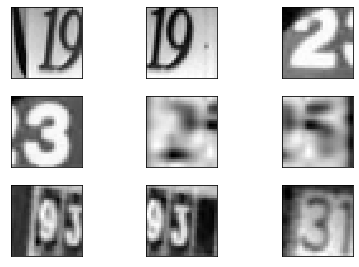

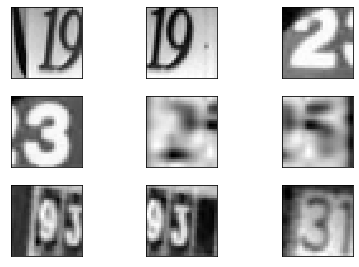

In [4]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train_resized[i].reshape((28,28)), cmap='gray', interpolation='none')
  #plt.title("Digit: {}".format(Y_train[i]))
  plt.xticks([])
  plt.yticks([])
fig

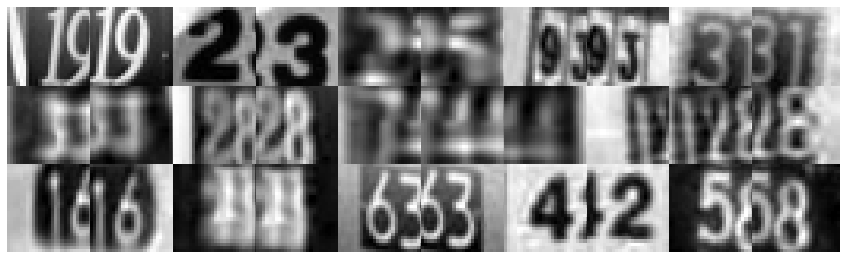

In [5]:
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(X_train_resized[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

# Set up different models varies in poolings

## 32 64 128 256 512 1024 2048 4096

## 2 4 8 16 32

In [6]:
nets = 14
model = [0] *nets

for i in range(nets):
    model[i] = tf.keras.models.Sequential()
    model[i].add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model[i].add(tf.keras.layers.BatchNormalization()) 
    model[i].add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model[i].add(tf.keras.layers.BatchNormalization())
    model[i].add(tf.keras.layers.Conv2D(32, (5, 5),strides=2,padding='same', activation='relu'))
    model[i].add(tf.keras.layers.BatchNormalization())
    model[i].add(tf.keras.layers.Dropout(0.4))
    
    model[i].add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model[i].add(tf.keras.layers.BatchNormalization())
    model[i].add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model[i].add(tf.keras.layers.BatchNormalization())
    model[i].add(tf.keras.layers.Conv2D(64, (5, 5),strides=2,padding='same', activation='relu'))
    model[i].add(tf.keras.layers.BatchNormalization())
    model[i].add(tf.keras.layers.Dropout(0.4))    
    
    model[i].add(tf.keras.layers.Flatten())
    model[i].add(tf.keras.layers.Dense(2**(i+1), activation=tf.nn.relu))
    model[i].add(tf.keras.layers.BatchNormalization())
    model[i].add(tf.keras.layers.Dropout(0.4))
    model[i].add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))
    model[i].compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
epochs = 20
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x+epochs))
# Split validation set
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train_resized, y_train, test_size = 0.333)
# Training
history = [0] * nets
names = ["2N","4N","8N","16N","32N","64N","128N","256N","512N","1024N","2048N","4096N","8192N","16384N","32768N"]

for j in range(nets):
    history[j] = model[j].fit(X_train2,Y_train2, batch_size=80, epochs = epochs, 
        validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[j],epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))

Instructions for updating:
Use tf.cast instead.
CNN 2N: Epochs=20, Train accuracy=0.44257, Validation accuracy=0.82746
CNN 4N: Epochs=20, Train accuracy=0.65847, Validation accuracy=0.93040
CNN 8N: Epochs=20, Train accuracy=0.86141, Validation accuracy=0.93872
CNN 16N: Epochs=20, Train accuracy=0.93510, Validation accuracy=0.93991
CNN 32N: Epochs=20, Train accuracy=0.94024, Validation accuracy=0.93786
CNN 64N: Epochs=20, Train accuracy=0.94519, Validation accuracy=0.94003
CNN 128N: Epochs=20, Train accuracy=0.94675, Validation accuracy=0.93896
CNN 256N: Epochs=20, Train accuracy=0.94830, Validation accuracy=0.94282
CNN 512N: Epochs=20, Train accuracy=0.95219, Validation accuracy=0.94245
CNN 1024N: Epochs=20, Train accuracy=0.95725, Validation accuracy=0.94118
CNN 2048N: Epochs=20, Train accuracy=0.96357, Validation accuracy=0.93847
CNN 4096N: Epochs=20, Train accuracy=0.96599, Validation accuracy=0.94044
CNN 8192N: Epochs=20, Train accuracy=0.96854, Validation accuracy=0.93827
CNN 1638

In [8]:

from keras.models import load_model
for j in range(nets):
    modelname = 'model'+str(j)+' svhn2 '+'32768_2'+'.h5'
    print(modelname+' saved')
    model[j].save(modelname)  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model


model0 svhn2 32768_1.h5 saved
model1 svhn2 32768_1.h5 saved
model2 svhn2 32768_1.h5 saved
model3 svhn2 32768_1.h5 saved
model4 svhn2 32768_1.h5 saved
model5 svhn2 32768_1.h5 saved
model6 svhn2 32768_1.h5 saved
model7 svhn2 32768_1.h5 saved
model8 svhn2 32768_1.h5 saved
model9 svhn2 32768_1.h5 saved
model10 svhn2 32768_1.h5 saved
model11 svhn2 32768_1.h5 saved
model12 svhn2 32768_1.h5 saved
model13 svhn2 32768_1.h5 saved


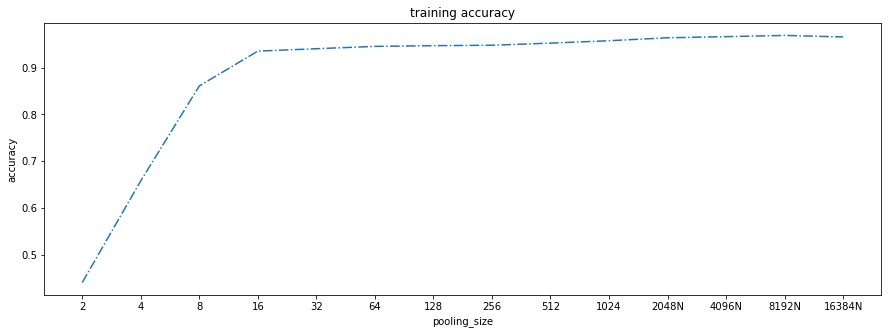

In [9]:
# PLOT ACCURACIES
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']
pooling_size = ['2','4','8','16','32','64','128','256','512','1024',"2048N","4096N","8192N","16384N"]

plt.figure(figsize=(15,5))
#for i in range(nets):
hi = [history[0].history['acc'][-1],history[1].history['acc'][-1],history[2].history['acc'][-1],history[3].history['acc'][-1],history[4].history['acc'][-1],history[5].history['acc'][-1],history[6].history['acc'][-1],history[7].history['acc'][-1],history[8].history['acc'][-1],history[9].history['acc'][-1],history[10].history['acc'][-1],history[11].history['acc'][-1],history[12].history['acc'][-1],history[13].history['acc'][-1]]
plt.plot(pooling_size,hi,linestyle=styles[1])
plt.title('training accuracy')
plt.ylabel('accuracy')
plt.xlabel('pooling_size')
#plt.legend(names, loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1])
plt.show()

In [6]:
'''
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (5, 5),strides=2,padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),   
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (5, 5),strides=2,padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),   
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),   
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

'''

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
'''
epochs = 30
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x+epochs))
history = model.fit_generator(train_datagen.flow(X_train_kaggle, Y_train_kaggle, batch_size=64),
                              steps_per_epoch=(X_train.shape[0]) / 64,
                              epochs=epochs,
                              callbacks=[annealer])
'''

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
657/657 [==============================] - 10s 15ms/step - loss: 0.5943 - acc: 0.8166
Epoch 2/30
657/657 [==============================] - 8s 12ms/step - loss: 0.1445 - acc: 0.9569
Epoch 3/30
657/657 [==============================] - 8s 12ms/step - loss: 0.0907 - acc: 0.9717
Epoch 4/30
657/657 [==============================] - 8s 12ms/step - loss: 0.0722 - acc: 0.9781
Epoch 5/30
657/657 [==============================] - 8s 12ms/step - loss: 0.0601 - acc: 0.9820
Epoch 6/30
657/657 [==============================] - 8s 12ms/step - loss: 0.0503 - acc: 0.9847
Epoch 7/30
657/657 [==============================] - 8s 12ms/step - loss: 0.0429 - acc: 0.9866
Epoch 8/30
657/657 [==============================] - 8s 12ms/step - loss: 0.0407 - acc: 0.9876
Epoch 9/30
657/657 [==============================] - 8s 12ms/step - loss: 0.0366 - acc: 0.9889
Epoch 10/30
657/657 [==============================] - 8s 12ms/step - loss: 0.0345 - ac

In [28]:
model[4].evaluate(X_test_resized,y_test)

26032/26032 [==============================] - 2s 88us/sample - loss: 0.2157 - acc: 0.9405


[0.21571906640228128, 0.9405347]

In [ ]:
# KAGGLE
results = model.predict_generator(validation_datagen.flow(X_test_kaggle))
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("MNIST-CNN.csv",index=False)
print(results)